# Machine Learning Classification Project - SMS Spam Detection

### Table of Content
<hr>

- [IMPORTS](#1)
- [Loading Data](#2)
- [Data Cleaning](#3)
- [EDA](#4)
-[Data Preprocessing](#5)
-[Model Buiding](#6)
-[Model](#7)

### Introduction To Dataset 
<hr>

**Context**

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

**Content**

The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

This corpus has been collected from free or free for research sources at the Internet:

-> A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages.

-> A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. 


-> Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available. This corpus has been used in the following academic researches:

### IMPORTS <a name="1"></a>
<hr>

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import seaborn as sns
from string import punctuation
from wordcloud import WordCloud
from collections import Counter
import pickle

### Loading Data <a name="2"></a>
<hr>

I was using a dataset downloaded from [Kaggle](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset) while reading this dataset it threw this error: UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf1 in position 183: invalid continuation byte

AS UCI had udated their dataset, so I had used [ISO 8859-1](https://www.w3schools.com/charsets/ref_html_8859.asp) single-byte encoding that can represent the first 256 Unicode characters 

In [2]:
data_df = pd.read_csv("spam.csv", encoding="ISO-8859-1")
data_df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [3]:
data_df.shape

(5572, 5)

### Data Cleaning <a name="3"></a>
<hr>

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
# As we can see the data information with not null counts. Hence, most of the data are in v1 and v2 columns,
# however columns such as Unnamed: 2, Unnamed: 3 and Unnamed: 4 have most missing values.So, lets drop this unwanted cols

data_df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
data_df.sample(10)

,v1,v2
503,ham,Lolnice. I went from a fish to ..water.?
4211,spam,Missed call alert. These numbers called but le...
3444,ham,wiskey Brandy Rum Gin Beer Vodka Scotch Shampa...
219,ham,Yeah you should. I think you can use your gt a...
2956,ham,I would but I'm still cozy. And exhausted from...
2909,ham,How do you guys go to see movies on your side.
2762,ham,ARR birthday today:) i wish him to get more os...
529,ham,Jay says that you're a double-faggot
1935,ham,Did either of you have any idea's? Do you know...
1890,ham,Ok but knackered. Just came home and went to s...


In [6]:
# Now, we got our desired dataframe. Furthermore, we have to rename our dataframe column's for better understanding 

data_df.rename(columns={"v1" : "Target",
                       "v2" : "Text"}, inplace=True)
data_df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Converting Target columns into binary : "ham" is classified as 0 and "spam" is classified as 1. Whereas, I can also use
 [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) for the same specific 
 work 


In [7]:
data_df["Target"] = data_df["Target"].apply(lambda x:1 if x=="spam" else 0)
data_df.sample(10)

,Target,Text
3589,0,I am in escape theatre now. . Going to watch K...
2012,0,Beautiful Truth against Gravity.. Read careful...
925,0,"K, wait chikku..il send aftr &lt;#&gt; mins"
3417,1,LIFE has never been this much fun and great un...
1545,0,"Good afternoon, my love ! Any job prospects ? ..."
4938,0,Tomarrow i want to got to court. At &lt;DECIM...
2702,0,"Omw back to tampa from west palm, you hear wha..."
5095,0,K.k.this month kotees birthday know?
1973,0,I had askd u a question some hours before. Its...
4397,0,Can you tell Shola to please go to college of ...


In [8]:
# finally our desired dataframe structure is ready now let's check missing values in our dataframe
data_df.isnull().sum()

Target    0
Text      0
dtype: int64

In [9]:
# Luckily we dont have any missing values, meanwhile I want to assure for duplicates values in our dataframe
duplicate_values = data_df.duplicated().sum()
print("Duplicate Values in our dataframe : {}".format(duplicate_values))

Duplicate Values in our dataframe : 403


In [10]:
# As I can see that there are 403 duplicate values in our df lets remover duplicates 
data_df = data_df.drop_duplicates(keep="first")
duplicate_values= data_df.duplicated().sum()
print("Duplicate Values in our dataframe : {}".format(duplicate_values))

Duplicate Values in our dataframe : 0


In [11]:
data_df.shape

(5169, 2)

### EDA <a name="4"></a>
<hr>

In [12]:
data_df["Target"].value_counts()

0    4516
1     653
Name: Target, dtype: int64

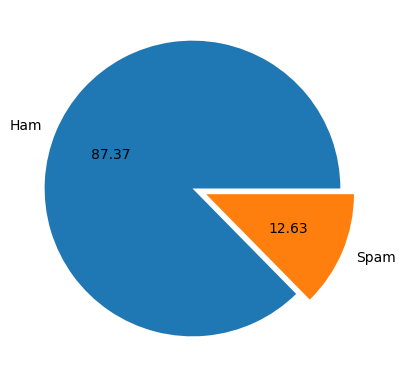

In [13]:
plt.pie(data_df["Target"].value_counts(), 
       labels=["Ham", "Spam"], 
       autopct="%0.2f",
       explode=[0.1, 0])
plt.show()

In [14]:
# Here I can see the situation of data imbalance, because of more contribution of ham into the data : approx 88%

In [15]:
# In addition, on further analysis I will count number of alphabets, words as well as sentenses into particular SMS  

In [16]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vasup\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
# 1. Creating new columns specially to count characters
data_df["Number_of_characters"] = data_df["Text"].apply(len)

C:\Users\vasup\AppData\Local\Temp\ipykernel_7328\3155905574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["Number_of_characters"] = data_df["Text"].apply(len)


In [18]:
# 2. Creating new columns specially to count words
data_df["Number_of_words"] = data_df["Text"].apply(lambda x : len(nltk.word_tokenize(x)))

C:\Users\vasup\AppData\Local\Temp\ipykernel_7328\1647956131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["Number_of_words"] = data_df["Text"].apply(lambda x : len(nltk.word_tokenize(x)))


In [19]:
# 3. Creating new columns specially to count sentences
data_df["Number_of_sentences"] = data_df["Text"].apply(lambda x : len(nltk.sent_tokenize(x)))

C:\Users\vasup\AppData\Local\Temp\ipykernel_7328\1139270374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["Number_of_sentences"] = data_df["Text"].apply(lambda x : len(nltk.sent_tokenize(x)))


In [20]:
data_df

,Target,Text,Number_of_characters,Number_of_words,Number_of_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2
5570,0,The guy did some bitching but I acted like i'd...,125,27,1


In [21]:
data_df[["Number_of_characters", "Number_of_words", "Number_of_sentences"]].describe()

,Number_of_characters,Number_of_words,Number_of_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [22]:
ham_describe = data_df[data_df["Target"]==0][["Number_of_characters", "Number_of_words", "Number_of_sentences"]].describe()
ham_describe

,Number_of_characters,Number_of_words,Number_of_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [23]:
spam_describe = data_df[data_df["Target"]==1][["Number_of_characters", "Number_of_words", "Number_of_sentences"]].describe()
spam_describe

,Number_of_characters,Number_of_words,Number_of_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


In [24]:
# Clearly, there is huge diffenct in statistical data when both ham and spam are compared. Because of more words and 
# charcaters are involed in spam SMS as compared to ham, which is mean(27.66), mean(137.39) 
# and mean(17.12), mean(70.45); respectivey

<AxesSubplot: xlabel='Number_of_characters', ylabel='Count'>

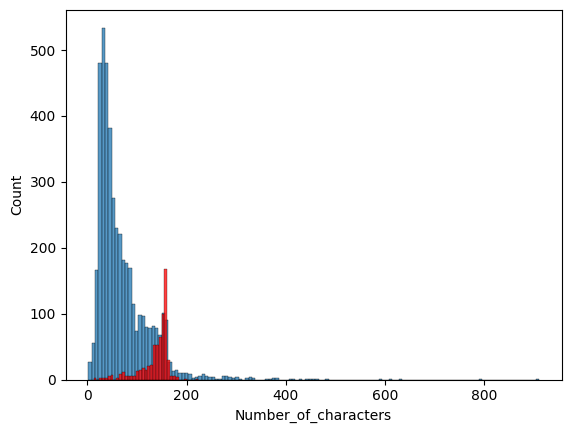

In [25]:
# Plotting number of character of hams in histogram for simpler understanding
sns.histplot(data_df[data_df["Target"]==0]["Number_of_characters"])
sns.histplot(data_df[data_df["Target"]==1]["Number_of_characters"], color="red")

<AxesSubplot: xlabel='Number_of_words', ylabel='Count'>

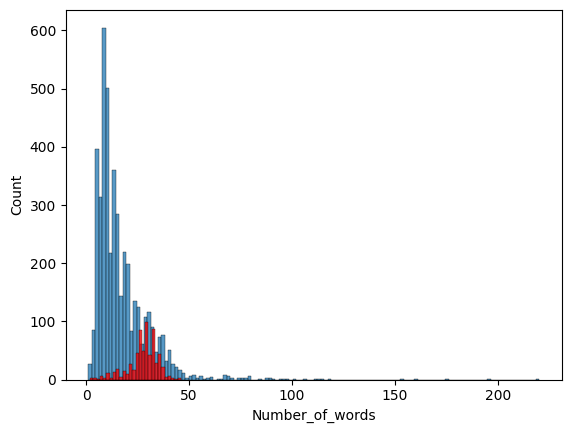

In [26]:
# Plotting number of words of hams in histogram for simpler understanding
sns.histplot(data_df[data_df["Target"]==0]["Number_of_words"])
sns.histplot(data_df[data_df["Target"]==1]["Number_of_words"], color="red")

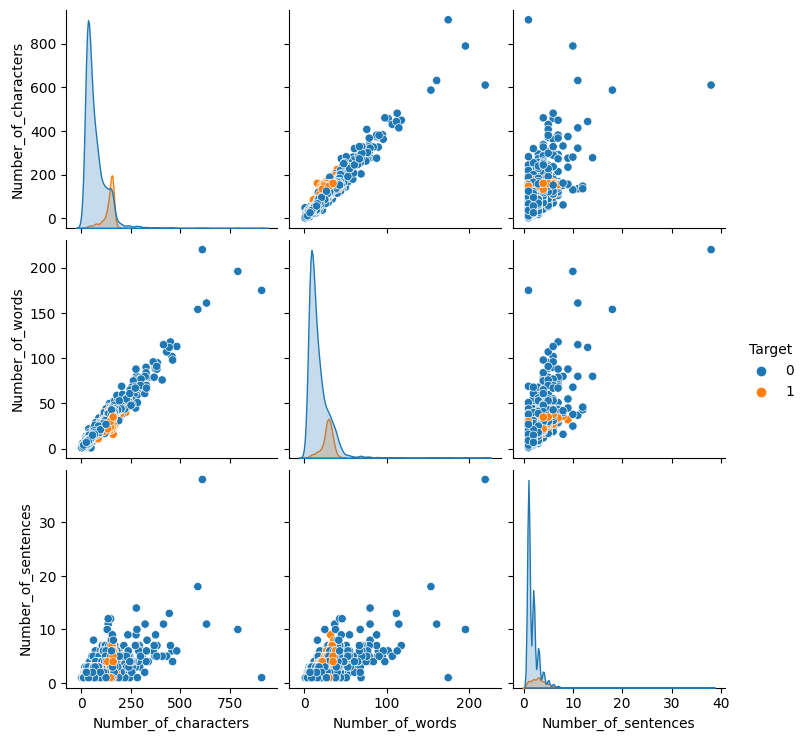

In [27]:
# lets check relation between columns
sns.pairplot(data_df, hue="Target")

In [28]:
# Although, data is partially linear, There are specific outliers which are hindering our analysis which I will resolve further

C:\Users\vasup\AppData\Local\Temp\ipykernel_7328\4268824876.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_df.corr(), annot=True)


<AxesSubplot: >

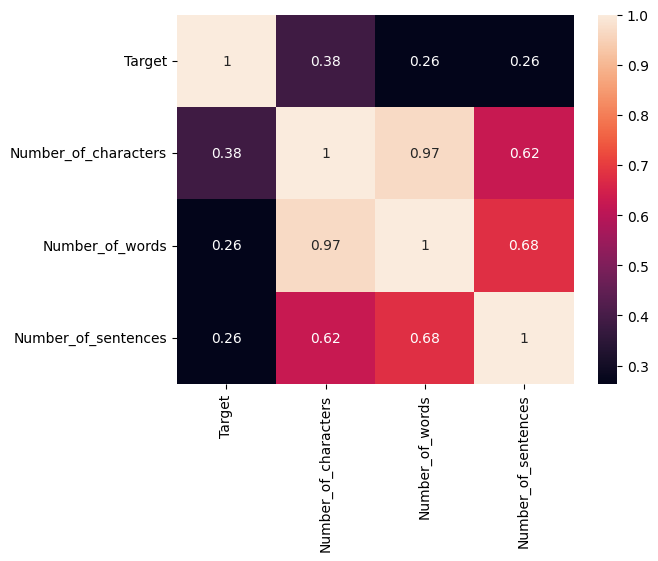

In [29]:
# lets check corelation 
sns.heatmap(data_df.corr(), annot=True)

 ### Data Preprocessing <a name="5"></a>
 <hr>
 
 - Lower case
 - Tokenization
 - Removing Special characters
 - Removing stop words and punctuations 
 - stemming

In [30]:
# I am creating function to do all the above work consequitively 

def Text_transformation(text):
    text = nltk.word_tokenize(text.lower())
    text = list(x for x in text if x.isalnum())
    text = list(x for x in text if x not in stopwords.words("english") and x not in punctuation)
    final_text = []
    porter = PorterStemmer()
    for i in text:
        final_text.append(porter.stem(i))
    return " ".join(final_text)

In [31]:
Text_transformation("hi VASU what are you doing today  !!")

'hi vasu today'

In [32]:
# Creating new column specifically for transformed text
data_df["Text_transformation"] = data_df["Text"].apply(Text_transformation)

C:\Users\vasup\AppData\Local\Temp\ipykernel_7328\741572995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["Text_transformation"] = data_df["Text"].apply(Text_transformation)


In [76]:
data_df

,Target,Text,Number_of_characters,Number_of_words,Number_of_sentences,Text_transformation
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4,2nd time tri 2 contact u pound prize 2 claim e...
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2,piti mood suggest
5570,0,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy someth els nex...


In [34]:
# Visulizing most words used in Target column

WC = WordCloud(width=700,
              height=700,
              min_font_size=10,
              background_color="white")

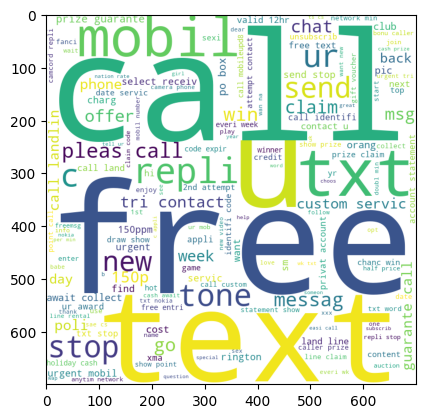

In [35]:
# Spam wordcloud
spam_wc = WC.generate(data_df[data_df["Target"]==1]["Text_transformation"].str.cat(sep=" "))
plt.imshow(spam_wc)

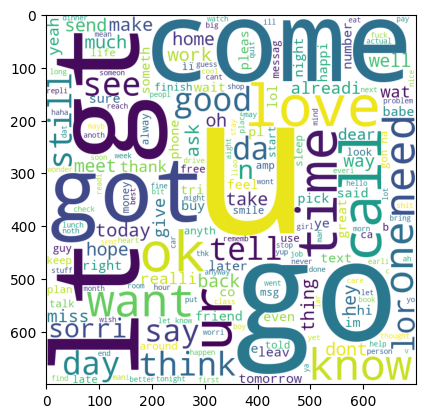

In [36]:
# ham wordcloud
ham_wc = WC.generate(data_df[data_df["Target"]==0]["Text_transformation"].str.cat(sep=" "))
plt.imshow(ham_wc)

In [37]:
spam_corpus = []
for msg in data_df[data_df["Target"]==1]["Text_transformation"].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [38]:
len(spam_corpus)

9939

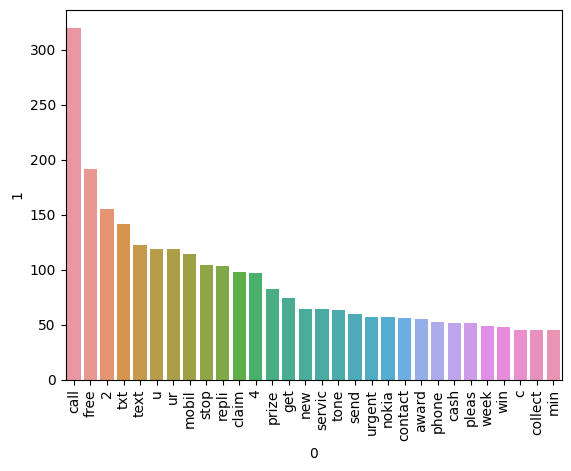

In [39]:
# Plotting 30 prior words used in spam SMS
sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0], 
           y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation="vertical")
plt.show()

In [40]:
ham_corpus = []
for msg in data_df[data_df["Target"]==0]["Text_transformation"].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [41]:
len(ham_corpus)

35404

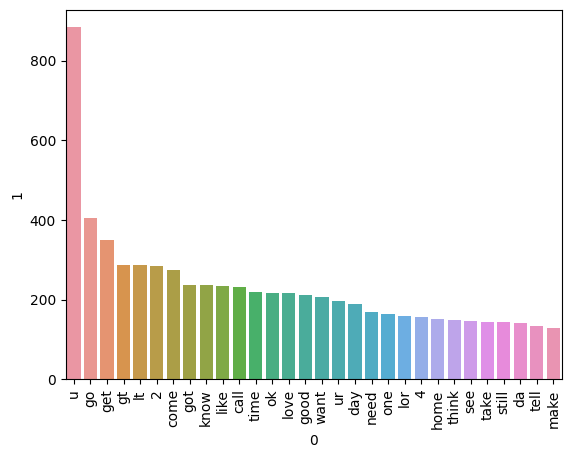

In [42]:
# Plotting 30 prior words used in ham SMS
sns.barplot(x=pd.DataFrame(Counter(ham_corpus).most_common(30))[0], 
           y=pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation="vertical")
plt.show()

### Model Buiding<a name="6"></a>
<hr>

In [43]:
# At the starting point we will use naive algorithm, because It is a straightforward and easy-to-implement 
# algorithm that makes it popular among other algorithms, it is used to find all the matching occurrences 
# of specified text in the given string.

# At the initial stage we will use countvectorizer

CV = CountVectorizer()
X = CV.fit_transform(data_df["Text_transformation"]).toarray()

In [44]:
X.shape

(5169, 6708)

In [45]:
y = data_df["Target"].values

In [46]:
# Creating train test split for X and y

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=2)

In [47]:
# Implementing 3 Naive Bayes classifiers
gnb, mnb, bnb = GaussianNB(), MultinomialNB(), BernoulliNB()

In [48]:
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred_gnb))
print(confusion_matrix(y_test, y_pred_gnb))
print(precision_score(y_test, y_pred_gnb))

0.8800773694390716
[[792 104]
 [ 20 118]]
0.5315315315315315


In [49]:
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred_mnb))
print(confusion_matrix(y_test, y_pred_mnb))
print(precision_score(y_test, y_pred_mnb))

0.9642166344294004
[[871  25]
 [ 12 126]]
0.8344370860927153


In [50]:
bnb.fit(X_train, y_train)
y_pred_bnb = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred_bnb))
print(confusion_matrix(y_test, y_pred_bnb))
print(precision_score(y_test, y_pred_bnb))

# Here BernoulliNB is performing good as compared to other classifiers, and also here precision score matters a lot because 
# of class inbalance in dataset

0.9700193423597679
[[893   3]
 [ 28 110]]
0.9734513274336283


In [51]:
# Now on the other stage we will use Tfidvectorizer
tfidf =TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data_df["Text_transformation"]).toarray()

In [52]:
# Scaling through min max sclaer because standard scaler also gives negative values and naive base 
# dont accept negative values

# scaler = MinMaxScaler()
# X = scaler.fit_transform(X) ------ Scaling fails in this dataset because reduces the precision and increasing the accuracy

In [53]:
X.shape

(5169, 3000)

In [54]:
y = data_df["Target"].values

In [55]:
# Creating train test split for X and y of tfid

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=2)

In [56]:
# again Implementing 3 Naive Bayes classifiers
gnb, mnb, bnb = GaussianNB(), MultinomialNB(), BernoulliNB()

In [57]:
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred_gnb))
print(confusion_matrix(y_test, y_pred_gnb))
print(precision_score(y_test, y_pred_gnb))

0.8694390715667312
[[788 108]
 [ 27 111]]
0.5068493150684932


In [58]:
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred_mnb))
print(confusion_matrix(y_test, y_pred_mnb))
print(precision_score(y_test, y_pred_mnb))
# Here MultinomialNB is performing excelent and showed precision score 1, as i had mention above that precision score
# matters a lot in this model because of class inbalance rather than accuracy

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0


In [59]:
bnb.fit(X_train, y_train)
y_pred_bnb = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred_bnb))
print(confusion_matrix(y_test, y_pred_bnb))
print(precision_score(y_test, y_pred_bnb))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


In [60]:
# Furthermore, I ll be working on tfidf. For the safer side I am also comparing with every possible classifiers in sklearn
svc = SVC(kernel="sigmoid", gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver="liblinear", penalty="l1")
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc  = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)

In [61]:
# Creating dict for classifiers

classifiers = {
    "SVC" : svc,
    "KN" : knc,
    "NB" : mnb,
    "DT" : dtc,
    "LR" : lrc,
    "RF" : rfc,
    "AdaBoost" : abc,
    "BgC" : bc,
    "ETC" : etc,
    "GBDT" :gbdt,
    "xgb" : xgb
}

In [62]:
# building training classifier 

def Train_classifier(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    return accuracy, precision

In [63]:
# creating loop for every classifies and checking out accuracy and precision
accuracy_scores = []
precision_scores = []

for name, classifier in classifiers.items():
    current_accuracy, current_precision = Train_classifier(classifier, X_train, y_train, X_test, y_test)
    print("Classifier : ",name)
    print("Accuracy : ", current_accuracy)
    print("Precision : ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)


Classifier :  SVC
Accuracy :  0.9758220502901354
Precision :  0.9747899159663865
Classifier :  KN
Accuracy :  0.9052224371373307
Precision :  1.0
Classifier :  NB
Accuracy :  0.9709864603481625
Precision :  1.0
Classifier :  DT
Accuracy :  0.9294003868471954
Precision :  0.8282828282828283
Classifier :  LR
Accuracy :  0.9584139264990329
Precision :  0.9702970297029703
Classifier :  RF
Accuracy :  0.9758220502901354
Precision :  0.9829059829059829
Classifier :  AdaBoost
Accuracy :  0.960348162475822
Precision :  0.9292035398230089
Classifier :  BgC
Accuracy :  0.9584139264990329
Precision :  0.8682170542635659
Classifier :  ETC
Accuracy :  0.9748549323017408
Precision :  0.9745762711864406
Classifier :  GBDT
Accuracy :  0.9468085106382979
Precision :  0.9191919191919192
Classifier :  xgb
Accuracy :  0.9671179883945842
Precision :  0.9333333333333333


In [64]:
performance_df = pd.DataFrame({"Algorithms":classifiers.keys(), 
                               "Accuracy":accuracy_scores,
                              "Precision":precision_scores}).sort_values("Precision", ascending=False)
performance_df
# As I can see that both NB and Rf are performing well in terms of precision fruther we ll 
# select one algo for final deployment

,Algorithms,Accuracy,Precision
1,KN,0.905222,1.000000
2,NB,0.970986,1.000000
5,RF,0.975822,0.982906
0,SVC,0.975822,0.974790
8,ETC,0.974855,0.974576
4,LR,0.958414,0.970297
10,xgb,0.967118,0.933333
6,AdaBoost,0.960348,0.929204
9,GBDT,0.946809,0.919192
7,BgC,0.958414,0.868217


In [65]:
# lets tune Nb algorithm by applying hyperparamerter of max_features_3000 in the above 
# block of code and see the outcome and differences after tuning

In [66]:
# temp_df = pd.DataFrame({"Algorithms":classifiers.keys(), 
#                                "Accuracy_max_ft_3000":accuracy_scores,
#                               "Precision_max_ft_3000":precision_scores}).sort_values("Precision_max_ft_3000", ascending=False)
# new_df = performance_df.merge(temp_df, on="Algorithms")
# new_df

In [67]:
# scaling MinMax on tfidf failed the task as it reduces the precision and increasing the accuracy, which is not optimum 
# in the model because od class inbalance

# so we will be focusing on NB with precision with max_features of 3000
pd.DataFrame(performance_df[["Accuracy", "Precision"]].iloc[1:2])

,Accuracy,Precision
2,0.970986,1.0


In [68]:
# lastly, lets try stacking classifier 

# Stacking Classifier

scv = SVC(kernel="sigmoid", gamma=1.0, probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

estimators=[("svm", svc), ("nb", mnb), ("et", etc)]
final_estimator = RandomForestClassifier()

In [69]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [70]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
# well stacking is also not working efficiently, I must stick to nb with max_feature=3000

Accuuracy 0.9787234042553191
Precision 0.9393939393939394


In [71]:
# Final step before deploying 

In [79]:
# pickle.dump(tfidf, open("vectorizer.pkl", "wb"))
# pickle.dump(mnb, open("model.pkl", "wb"))

### Model<a name="7"></a>
<hr>

In [82]:
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred_mnb))
print(confusion_matrix(y_test, y_pred_mnb))
print(precision_score(y_test, y_pred_mnb))

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0
